# Correlation vs Similarity

DS 5001 Text as Data

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_hone = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [4]:
data_prefix = 'austen-melville'
OHCO = ['book_id', 'chap_id']
colors = "YlGnBu"

In [5]:
import pandas as pd
import numpy as np

In [6]:
import plotly_express as px
import seaborn as sns; sns.set()

In [8]:
import sys
sys.path.append(local_lib)
from hac2 import HAC

# Get Data

In [11]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB_LABELS.csv").set_index(OHCO[:1])

In [89]:
LIB.head()

,source_file_path,author,title,chap_regex,book_len,n_chaps,label,y_raw_2,y_L0_2,y_L1_2,y_L2_2,y_raw_4,y_L0_4,y_L1_4,y_L2_4,kendall_sum,r_mean
book_id,,,,,,,,,,,,,,,,,
105,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,Austen: Persuasion (105),0,1,1,1,2,0,3,2,7.020240,0.422118
121,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,Austen: Northanger Abbey (121),0,1,1,1,2,0,2,2,7.039617,0.423138
141,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,Austen: Mansfield Park (141),0,0,1,1,2,0,3,2,7.021093,0.422163
158,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,Austen: Emma (158),0,1,1,1,2,0,3,2,6.974829,0.419728
161,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,Austen: Sense And Sensibilit (161),0,1,1,1,2,0,3,2,7.145034,0.428686


In [14]:
TFIDF = pd.read_csv(f"{output_dir}/{data_prefix}-TFIDF-BOOKS.csv").set_index(OHCO[:1])

In [67]:
TFIDF.head()

,0,1,10,100,1000,10000,10000000,10440,10800,10th,...,zoroaster,zozo,zuma,zur,à,æneas,æniad,æson,æsops,ł20000
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.0,0.000210,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
121,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
141,0.0,0.000000,0.000162,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000047
158,0.0,0.000000,0.000000,0.0,0.0,0.000203,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
161,0.0,0.000047,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# Correlation of Books

Use Pandas' `df.corr()` method to generate pairs. 

Correlation is normalized covariance, which is the dot product two vectors.

Note that Kendall’s correlation is non-parametric -- it does not require the two variables have a bell curve distribution.

In [16]:
# corr_type = 'pearson'
corr_type = 'kendall'
# corr_type = 'spearman'

In [26]:
CORR_MATRIX = TFIDF.T.corr(corr_type)

## Compare Correlations by Author

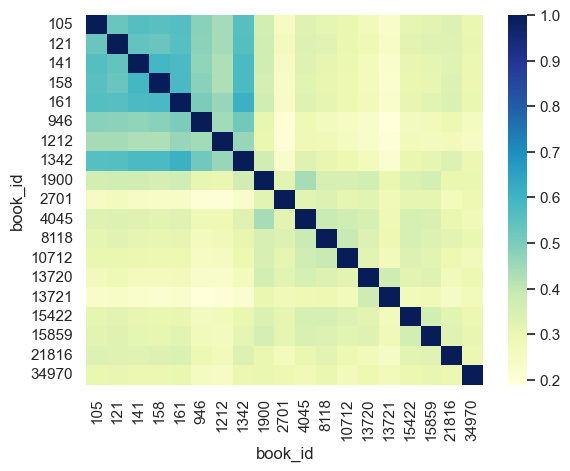

In [27]:
sns.heatmap(CORR_MATRIX, cmap=colors);

Find books that have the greatest correlations.

In [71]:
LIB['r_mean'] = CORR_MATRIX.mean()

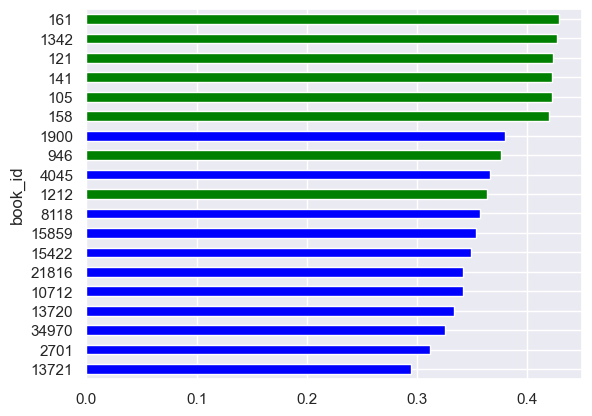

In [98]:
LIB.r_mean.sort_values().plot.barh(color=['green' if 'AUSTEN' in author else 'blue' for author in LIB.sort_values('r_mean').author]);

# Compare correlation sum to book length

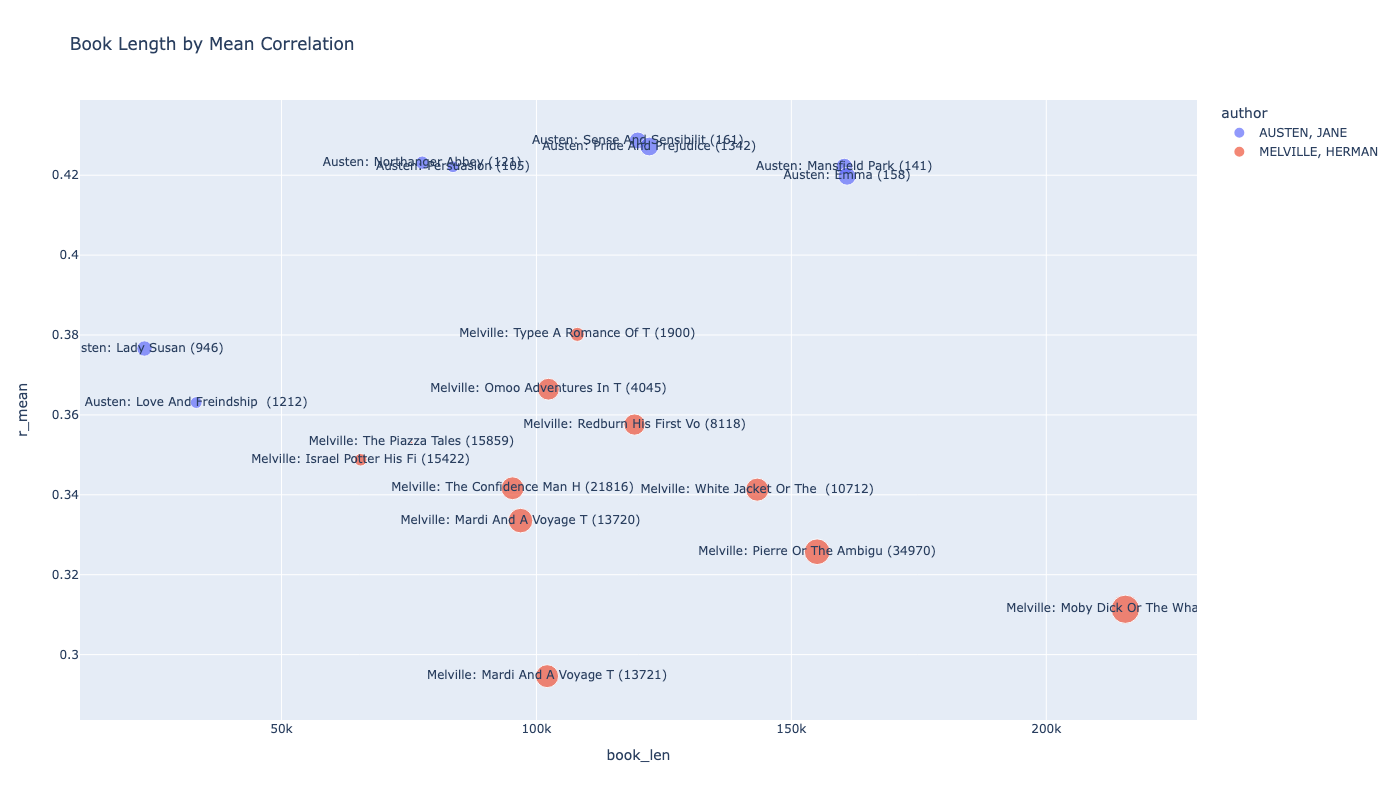

In [162]:
px.scatter(LIB.dropna(), 'book_len', 'r_mean', text='label', 
           height=800, width=950, 
           size="n_chaps", color="author", 
           title="Book Length by Mean Correlation")

Find out how correlated the works of each author is.

In [163]:
AUS_IDX = LIB[LIB.author.str.contains("AUS")].index.to_list()
MEL_IDX = LIB[LIB.author.str.contains("MEL")].index.to_list()

In [164]:
CM_A = CORR_MATRIX.loc[AUS_IDX, AUS_IDX]
CM_M = CORR_MATRIX.loc[MEL_IDX, MEL_IDX]

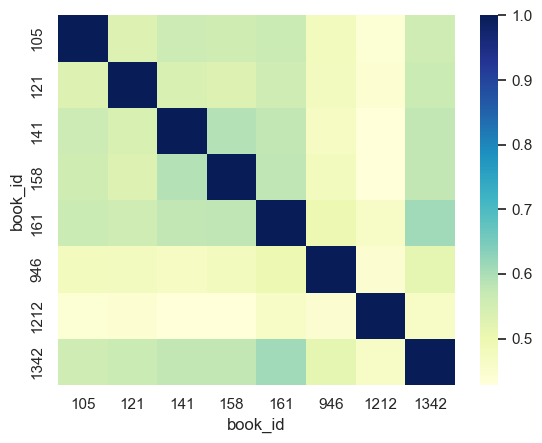

In [174]:
sns.heatmap(CM_A, cmap=colors);

In [166]:
CM_A.mean().mean()

0.5781083863722681

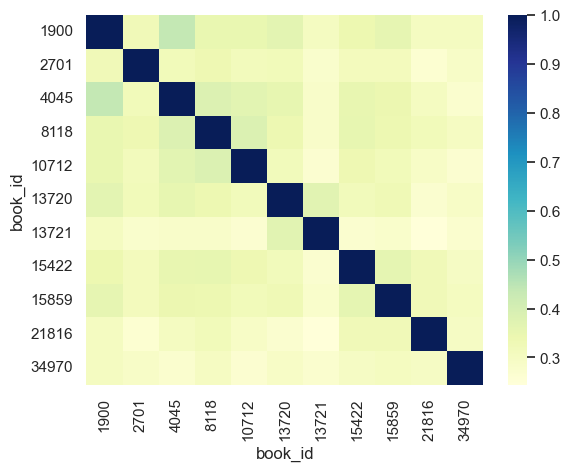

In [167]:
sns.heatmap(CM_M, cmap=colors);

In [168]:
CM_M.mean().mean()

0.3798148364330917

## Hierarchical 

Are correlations good for clustering?

In [47]:
CORR = CORR_MATRIX.stack().to_frame('r').sort_index()
# CORR.index.names = ['doc_a', 'doc_b']
# CORR = CORR.query('doc_a < doc_b')

In [48]:
X = CORR['r'].unstack()

<Figure size 640x480 with 0 Axes>

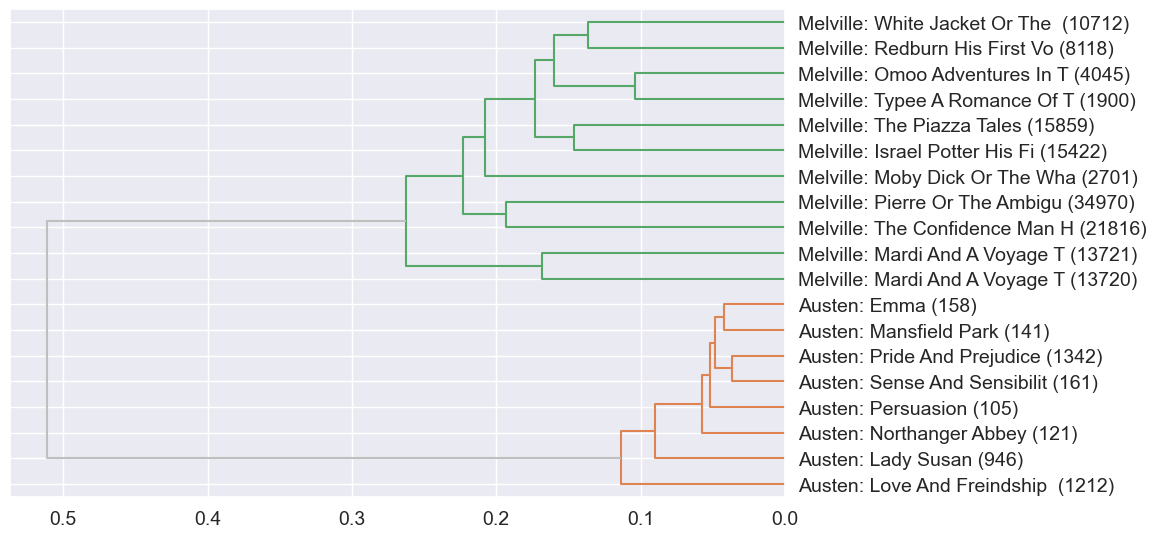

In [49]:
fig = HAC(X, labels=LIB.label.to_list())
fig.color_thresh = .3
fig.plot()

Correlation is not a distance measure in vector space. 

- It measures the **degree of association** between two variables. 
- It measure the **strength and direction of the relationship** between two variables

So, although both correlation and distance measures concern the relationship between variables, they are fundamentally different concepts and are used for different purposes. 

# Correlation of Words

In [61]:
CORR_MATRIX_W = TFIDF.T.sample(100).T.corr(corr_type)

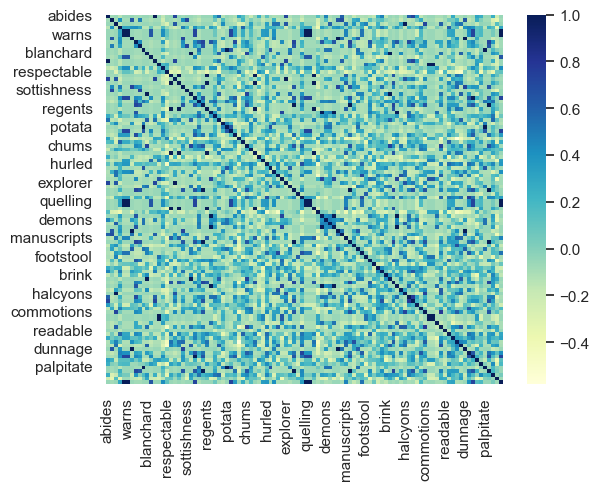

In [62]:
sns.heatmap(CORR_MATRIX_W, cmap=colors);

In [63]:
CORR_W = CORR_MATRIX_W.stack().to_frame('r').sort_index()

In [64]:
XW= CORR_W['r'].unstack()

<Figure size 640x480 with 0 Axes>

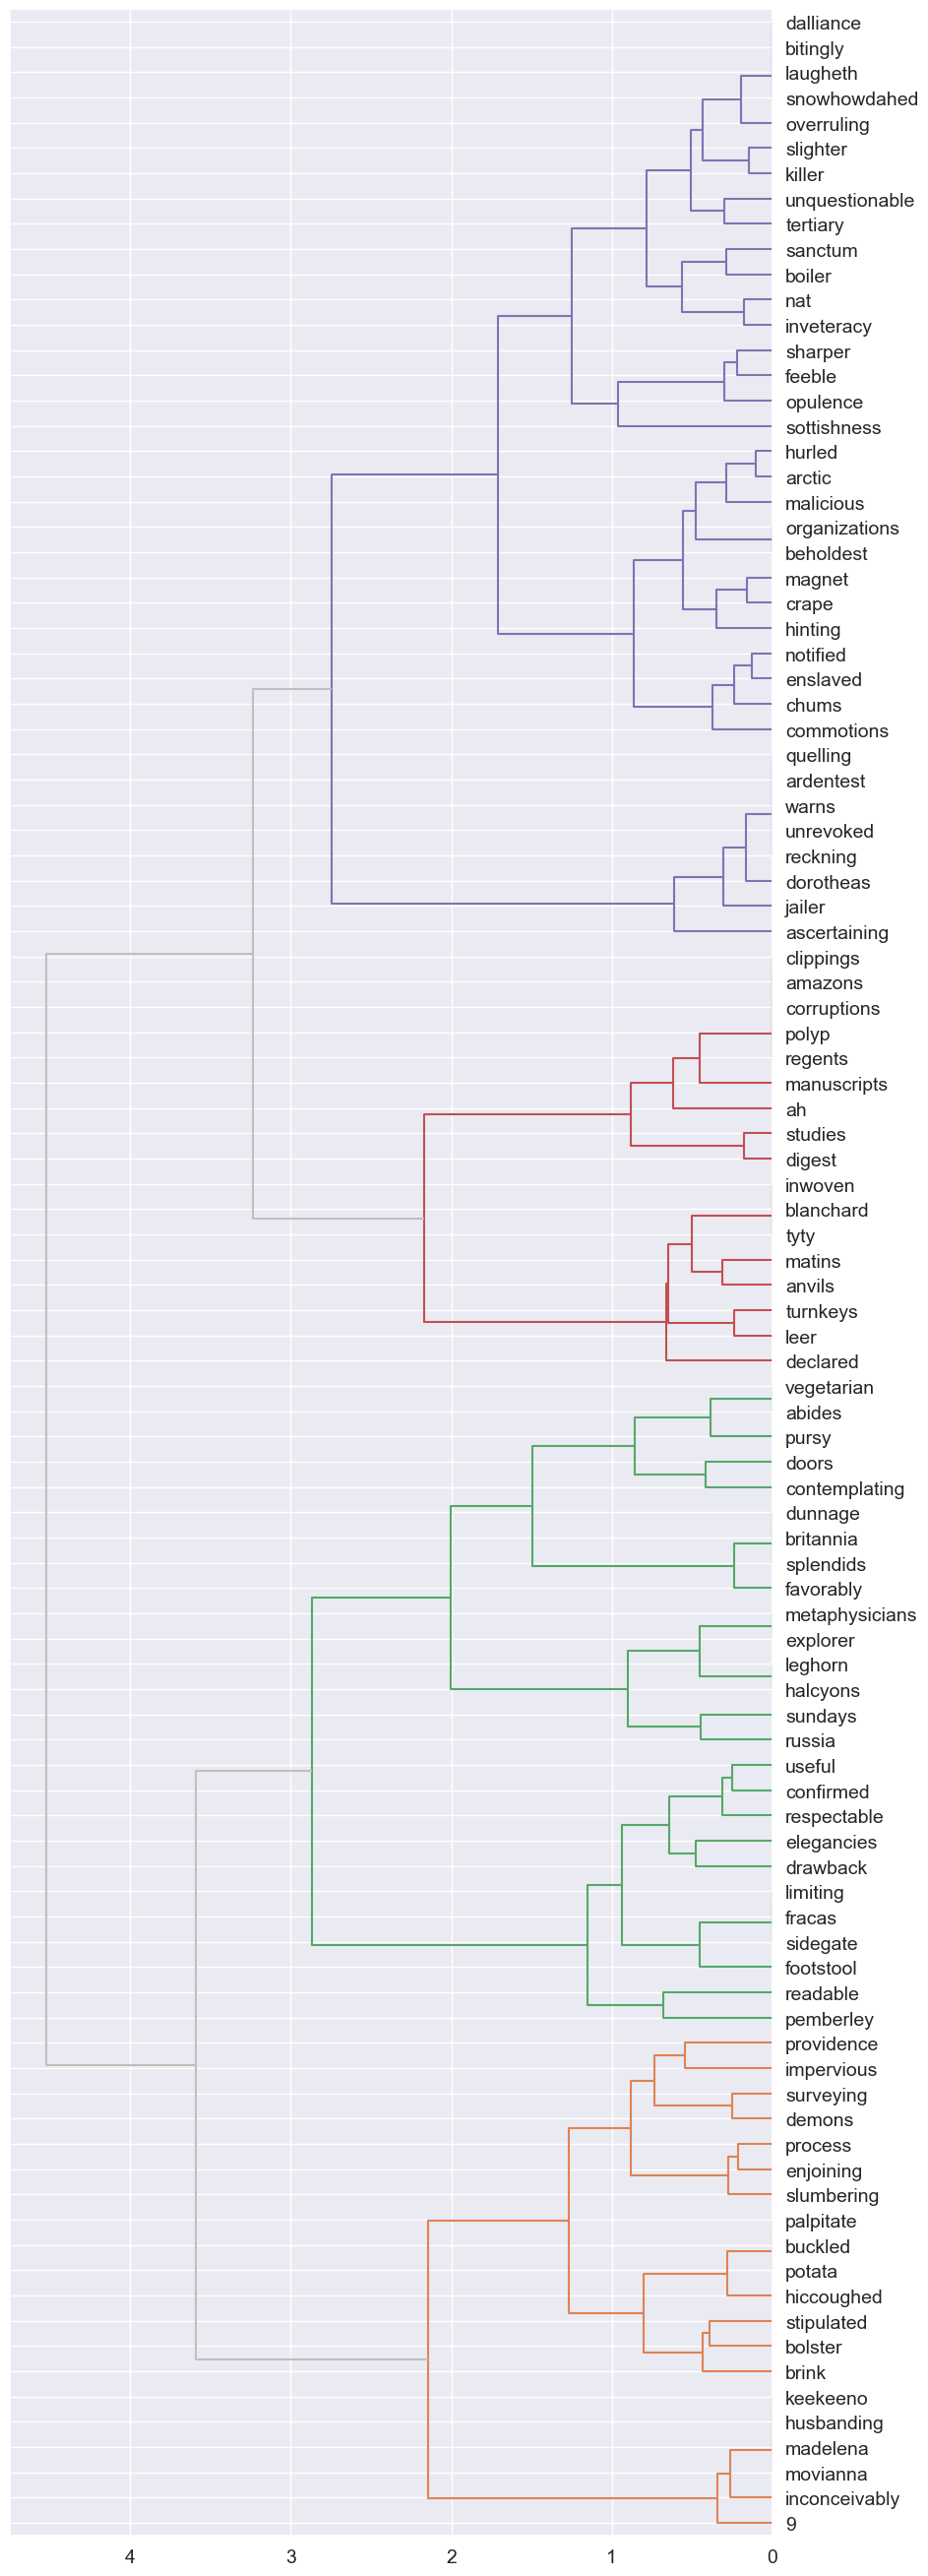

In [66]:
fig = HAC(XW)
fig.color_thresh = 3
fig.plot()